# Import

In [63]:
import numpy as np
import pandas as pd
import nltk
import re
import string
from tqdm import tqdm, tqdm_notebook

In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk.collocations import QuadgramAssocMeasures, QuadgramCollocationFinder

In [66]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


# TF-DF Measure

In [67]:
stopWords = stopwords.words('english')
sw = set(stopWords) -set([ "it's", 'who', 'whom', 'is','in','of','for','are', 'was', 'were', 'be',
    'being', 'have', 'has','an', 'had', 'having', 'do', 'does', 'did', 'doing',"a", 'other','or', 'some',  'no', 'not', 'own', 'same', 'can', 'don', "don't", 'should',
     'now','will','such','as','can','the','that'])


## 1 gram

In [68]:
def TF_IDF_1gram(corpus,filtre ) :
    count_vec = CountVectorizer(ngram_range = (1,1)  ,stop_words = sw)
    
    tf_result    = count_vec.fit_transform(corpus)
    tf_result_df = pd.DataFrame(tf_result.toarray()
                                   ,columns=count_vec.get_feature_names()) #3

    the_sum_s = tf_result_df.sum(axis=0) 
    the_sum_df = pd.DataFrame({ 
        'keyword':the_sum_s.index
        ,'tf_sum':the_sum_s.values
    })

    the_sum_df = the_sum_df[the_sum_df['tf_sum']>filtre ].sort_values(by=['tf_sum'],ascending=False)
    my_word_df = the_sum_df[the_sum_df['keyword'].str.len()>2]
    return the_sum_df

## Bi gram

In [69]:
def TF_IDF_2gram(corpus,filtre) :
    lemmatizer = WordNetLemmatizer()

    text_set_words = []
    for s in corpus :
        words = word_tokenize(s)
        words = [lemmatizer.lemmatize(word) for word in words if not word in sw]
        text_set_words.append(words)
    #print(text_set_words)
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_documents(text_set_words) 
    finder.apply_freq_filter(filtre) #3 filtre par frequence
    finder.apply_word_filter(lambda w:len(w) < 3 or len(w) > 15 ) 
    phrase_result = finder.nbest(bigram_measures.pmi, 20000) 
    colloc_strings = [w1+' '+w2 for w1,w2 in phrase_result]
    return colloc_strings

## Tri gram


In [70]:
def TF_IDF_3gram(corpus,filtre) :
    lemmatizer = WordNetLemmatizer()
    text_set_words = []
    for s in corpus :
        words = word_tokenize(s)
        words = [lemmatizer.lemmatize(word) for word in words if not word in sw]
        text_set_words.append(words)

    trigram_measures = TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_documents(text_set_words)
    finder.apply_freq_filter(filtre)
    finder.apply_word_filter(lambda w: 
                             len(w) < 3 
                             or len(w) > 15 
                             )
    tri_phrase_result = finder.nbest(trigram_measures.pmi, 1000)
    tri_colloc_strings = [w1+' '+w2+' '+w3 for w1,w2,w3 in tri_phrase_result] 
    return tri_colloc_strings

## Quadgram

In [71]:
def TF_IDF_4gram(corpus,filtre) :
    lemmatizer = WordNetLemmatizer()
    text_set_words = []
    for s in corpus :
        words = word_tokenize(s)
        words = [lemmatizer.lemmatize(word) for word in words if not word in sw]
        text_set_words.append(words)

    Quadgram_measures = QuadgramAssocMeasures()
    finder = QuadgramCollocationFinder.from_documents(text_set_words)
    finder.apply_freq_filter(filtre)
    finder.apply_word_filter(lambda w: 
                             len(w) < 3 
                             or len(w) > 15 
                             )
    Quad_phrase_result = finder.nbest(Quadgram_measures.pmi, 1000)
    Quad_colloc_strings = [w1+' '+w2+' '+w3+' '+w4 for w1,w2,w3,w4 in Quad_phrase_result] 
    return Quad_colloc_strings

## N gram

In [72]:
def combine_ngram(corpus,filtre1,filtre2,filtre3,filtre4):
    my_word_df = TF_IDF_1gram(corpus,filtre1)
    colloc_strings = TF_IDF_2gram(corpus,filtre2)
    tri_colloc_strings = TF_IDF_3gram(corpus,filtre3)
    Quad_colloc_strings = TF_IDF_4gram(corpus,filtre4)
    

    my_vocabulary = []
    my_vocabulary.extend(my_word_df['keyword'].tolist()) 
    my_vocabulary.extend(colloc_strings)
    my_vocabulary.extend(tri_colloc_strings)
    my_vocabulary.extend(Quad_colloc_strings)
    return my_vocabulary

In [73]:
def dataframe_ngram_tf_idf(my_vocabulary,corpus) :
    
    vec          = TfidfVectorizer(
                        analyzer     ='word'
                        ,ngram_range =(1, 4)
                        ,vocabulary  = my_vocabulary)
    text_set     = corpus
    tf_idf       = vec.fit_transform(text_set)
    result_tfidf = pd.DataFrame(tf_idf.toarray()
                                , columns=vec.get_feature_names()) 
    return  result_tfidf

In [74]:
def tf_idf_row(row):
    keywords_df = pd.DataFrame({
        'keyword':row.index,
        'tf-idf':row.values
    })
    keywords_df = keywords_df[ keywords_df['tf-idf'] >0].sort_values(by=['tf-idf'],ascending=False)
    
 #   print(keywords_df[:3])
    bigram_words = [item.split() 
                        for item in keywords_df['keyword'].tolist() 
                        if len(item.split())==2]
    bigram_words_set = set(subitem 
                            for item in bigram_words 
                            for subitem in item) 
    keywords_df_new = keywords_df[~keywords_df['keyword'].isin(bigram_words_set)]
   # print('\n',keywords_df_new[:1],'\n_________________________________')

    trigram_words = [item.split() 
                        for item in keywords_df['keyword'].tolist() 
                        if len(item.split())==3]
    trigram_words_set = set(subitem 
                            for item in trigram_words 
                            for subitem in item) 
    keywords_df_new = keywords_df[~keywords_df['keyword'].isin(trigram_words_set)]
   # print('\n',keywords_df_new[:1],'\n_________________________________')

    Quadgram_words = [item.split() 
                        for item in keywords_df['keyword'].tolist() 
                        if len(item.split())==4]
    Quadgram_words_set = set(subitem 
                            for item in Quadgram_words 
                            for subitem in item) 
    keywords_df_new = keywords_df[~keywords_df['keyword'].isin(Quadgram_words_set)]
   # print('\n',keywords_df_new[:1],'\n_________________________________')

    return keywords_df_new

In [75]:
def TF_IDF_DataFrame(corpus,filtre1,filtre2,filtre3,filtre4) :
    
    my_vocabulary = combine_ngram(corpus,filtre1,filtre2,filtre3,filtre4)
    result_tfidf = dataframe_ngram_tf_idf(list(set(my_vocabulary)),corpus)
    df = pd.DataFrame(columns=['keyword','tf-idf'])

    for i in range(0,result_tfidf.shape[0]) :
        test_tfidf_row = result_tfidf.loc[i]   
        df = df.append(tf_idf_row(test_tfidf_row),ignore_index = True)

    df = df.sort_values(by=['tf-idf'],ascending=False)
    df = df.drop_duplicates(subset=['keyword'])
    return df

In [76]:
def TF_IDF_DataFrame2(corpus,VOCAB) :
    
    my_vocabulary = VOCAB
    result_tfidf = dataframe_ngram_tf_idf(list(set(my_vocabulary)),corpus)
    df = pd.DataFrame(columns=['keyword','tf-idf'])

    for i in range(0,result_tfidf.shape[0]) :
        test_tfidf_row = result_tfidf.loc[i]   
        df = df.append(tf_idf_row(test_tfidf_row),ignore_index = True)

    df = df.sort_values(by=['tf-idf'],ascending=False)
    df = df.drop_duplicates(subset=['keyword'])
    return df

In [77]:
df =pd.read_json('FDF_for_amine.json')

In [78]:
df.columns

Index(['Section', 'Title', 'Relation_type', 'Corpus', 'Similarity', 'Keywords',
       'Entities', 'Ref', 'Definition', 'Concept_range', 'Synonyms',
       'Relation_Non_Taxonomique'],
      dtype='object')

In [79]:
#df['Corpus'][0]

In [80]:
final_concepts = []
final_concepts.extend(df['Title'].tolist())
#final_concepts.extend(prs1)

In [81]:
#final_concepts

In [82]:
df

,Section,Title,Relation_type,Corpus,Similarity,Keywords,Entities,Ref,Definition,Concept_range,Synonyms,Relation_Non_Taxonomique
0,1.0.0.0,Project scope management,,Project Scope Management includes the process ...,"[[scope, 0.4459], [objectives, 0.3474000000000...","[[scope, 0.48860000000000003], [management, 0....","[[[Project, Scope, Management]], [[process]], ...","[[[[['Figure 5-1'], []], []], []], []]",Project Scope Management includes the process ...,"[Project Scope Management, defining, Collect R...","[project, work, work, project, project scope, ...","[includes, required ensure, includes, required..."
1,1.1.0.0,Plan scope management,,Plan Scope Management is the process of creati...,"[[planning, 0.4174], [management, 0.3726000000...","[[scope, 0.48], [management, 0.313200000000000...","[[[Plan, Scope, Management]], [[process]], [[s...","[[[[['Figure 5-3', 'Figure 5-2'], []], ['Secti...",Plan Scope Management is the process of creati...,"[Plan Scope Management, process, scope managem...",[],"[is, creating, will be defined controlled, is ..."
2,1.1.1.1,Project charter,Inputs,Described in Section The project charter Docum...,"[[requirements, 0.5642], [charter, 0.4068], [p...","[[requirements, 0.5116], [constraints, 0.37260...","[[[Section]], [[project, charter, Document]], ...","[[[[[], []], ['Section 4.1.3.1']], ['Section 4...",The project charter Document the project purpo...,[],[],[]
3,1.1.1.2,Project management plan,Inputs,Described in Section Project management plan c...,"[[scope, 0.5049], [scheduling, 0.3523], [devel...","[[agile, 0.4672], [development, 0.409000000000...","[[[Section, Project, management, plan, commons...","[[[[[], []], ['Section 8.1.3.1', 'Section 4.2....",Project management plan commons include but ar...,"[Project management plan commons, organization...",[organization quality policy methodologies sta...,"[include are limited, will be managed can be i..."
4,1.1.1.3,Enterprise environmental factors,Inputs,The enterprise environmental factors that can ...,"[[enterprise, 0.3937], [requirements, 0.3749],...","[[scope, 0.4032], [enterprise, 0.3999000000000...","[[[enterprise]], [[factors]], [[Plan, Scope, M...","[[[[[], []], []], []], []]",The enterprise environmental factors that can ...,[enterprise factors],[],"[can influence, are limited]"
...,...,...,...,...,...,...,...,...,...,...,...,...
211,3.4.3.1,Work performance information,Outputs,Described in Section Work performance informat...,"[[duration, 0.376], [performance, 0.3265], [sp...","[[performance, 0.3573], [evaluated, 0.323], [r...","[[[Section, Work, performance, information]], ...","[[[[[], []], ['Section 4.5.1.3', 'Section 4.5....",Work performance information includes informat...,"[information project work, cost work, work pac...","[information project work, cost work]","[includes, is performing compared, performed, ..."
212,3.4.3.2,Cost forecasts,Outputs,Either a calculated A value or a bottom up A v...,"[[estimating, 0.5118], [estimates, 0.450800000...","[[stakeholders, 0.5412], [value, 0.4718], [cal...","[[[A, value]], [[value]]]","[[[[[], []], []], []], []]",Either a calculated A value or a bottom up A v...,[],[],"[calculated, is documented communicated]"
213,3.4.3.3,Change requests,Outputs,Described in Section Analysis of project perfo...,"[[scope, 0.3556], [section, 0.322], [managemen...","[[management, 0.3029], [section, 0.28700000000...","[[[Section, Analysis]], [[project, performance...","[[[[[], []], ['Section 4.3.3.4', 'Section 4.6'...",Analysis of project performance may result in ...,[Analysis project performance],[],"[may result, are proceed]"
214,3.4.3.4,Project management plan updates,Outputs,Any change to the project management plan goes...,"[[changes, 0.3584], [management, 0.2652], [sch...","[[changes, 0.3351], [scope, 0.2891], [performa...","[[[change]], [[project, management, plan]], [[...","[[[[[], []], ['Section 7.3.3.1', 'Section 7.1....",Any change to the project management plan goes...,"[change request project man

In [83]:
topic = []
for index,row in df.iterrows():
    if row['Section'][0] == '1':
        topic.append('Project scope management')
    if row['Section'][0] == '2':
        topic.append('Project schedule management')
    if row['Section'][0] == '3':
        topic.append('Project cost management')

In [84]:
df['topic'] = topic

In [85]:
df

,Section,Title,Relation_type,Corpus,Similarity,Keywords,Entities,Ref,Definition,Concept_range,Synonyms,Relation_Non_Taxonomique,topic
0,1.0.0.0,Project scope management,,Project Scope Management includes the process ...,"[[scope, 0.4459], [objectives, 0.3474000000000...","[[scope, 0.48860000000000003], [management, 0....","[[[Project, Scope, Management]], [[process]], ...","[[[[['Figure 5-1'], []], []], []], []]",Project Scope Management includes the process ...,"[Project Scope Management, defining, Collect R...","[project, work, work, project, project scope, ...","[includes, required ensure, includes, required...",Project scope management
1,1.1.0.0,Plan scope management,,Plan Scope Management is the process of creati...,"[[planning, 0.4174], [management, 0.3726000000...","[[scope, 0.48], [management, 0.313200000000000...","[[[Plan, Scope, Management]], [[process]], [[s...","[[[[['Figure 5-3', 'Figure 5-2'], []], ['Secti...",Plan Scope Management is the process of creati...,"[Plan Scope Management, process, scope managem...",[],"[is, creating, will be defined controlled, is ...",Project scope management
2,1.1.1.1,Project charter,Inputs,Described in Section The project charter Docum...,"[[requirements, 0.5642], [charter, 0.4068], [p...","[[requirements, 0.5116], [constraints, 0.37260...","[[[Section]], [[project, charter, Document]], ...","[[[[[], []], ['Section 4.1.3.1']], ['Section 4...",The project charter Document the project purpo...,[],[],[],Project scope management
3,1.1.1.2,Project management plan,Inputs,Described in Section Project management plan c...,"[[scope, 0.5049], [scheduling, 0.3523], [devel...","[[agile, 0.4672], [development, 0.409000000000...","[[[Section, Project, management, plan, commons...","[[[[[], []], ['Section 8.1.3.1', 'Section 4.2....",Project management plan commons include but ar...,"[Project management plan commons, organization...",[organization quality policy methodologies sta...,"[include are limited, will be managed can be i...",Project scope management
4,1.1.1.3,Enterprise environmental factors,Inputs,The enterprise environmental factors that can ...,"[[enterprise, 0.3937], [requirements, 0.3749],...","[[scope, 0.4032], [enterprise, 0.3999000000000...","[[[enterprise]], [[factors]], [[Plan, Scope, M...","[[[[[], []], []], []], []]",The enterprise environmental factors that can ...,[enterprise factors],[],"[can influence, are limited]",Project scope management
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,3.4.3.1,Work performance information,Outputs,Described in Section Work performance informat...,"[[duration, 0.376], [performance, 0.3265], [sp...","[[performance, 0.3573], [evaluated, 0.323], [r...","[[[Section, Work, performance, information]], ...","[[[[[], []], ['Section 4.5.1.3', 'Section 4.5....",Work performance information includes informat...,"[information project work, cost work, work pac...","[information project work, cost work]","[includes, is performing compared, performed, ...",Project cost management
212,3.4.3.2,Cost forecasts,Outputs,Either a calculated A value or a bottom up A v...,"[[estimating, 0.5118], [estimates, 0.450800000...","[[stakeholders, 0.5412], [value, 0.4718], [cal...","[[[A, value]], [[value]]]","[[[[[], []], []], []], []]",Either a calculated A value or a bottom up A v...,[],[],"[calculated, is documented communicated]",Project cost management
213,3.4.3.3,Change requests,Outputs,Described in Section Analysis of project perfo...,"[[scope, 0.3556], [section, 0.322], [managemen...","[[management, 0.3029], [section, 0.28700000000...","[[[Section, Analysis]], [[project, performance...","[[[[[], []], ['Section 4.3.3.4', 'Section 4.6'...",Analysis of project performance may result in ...,[Analysis project performance],[],"[may result, are proceed]",Project cost management
214,3.4.3.4,Project management plan updates,Outputs,Any change to the project management plan goes...,"[[changes, 0.3584], [management, 0.2652], [sch...","[[changes, 0.3351], [scope

In [86]:
df.to_json('fdf_for_marouene.json')

In [87]:
import warnings
warnings.filterwarnings("ignore")

# TF-IDF

In [88]:
concept_range_prelist = [row['Concept_range'] for i, row in df.iterrows()]


In [89]:
concept_range_list = [concept for concept2 in concept_range_prelist for concept in concept2 ]

In [90]:
myset = set(concept_range_list)
concept_range_list = list(myset)

In [91]:
len(concept_range_list)

1300

In [92]:
def words_weight_df(corpus,vectorizer):
        weight_matrix = vectorizer.fit_transform(corpus)
        return pd.DataFrame(weight_matrix.toarray(),columns=vectorizer.get_feature_names())

In [93]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 5),min_df=0.01,vocabulary  = concept_range_list)
df_weights=words_weight_df(df['Definition'],tfidf_vect)

In [94]:
df_weights

,types quantities resources,loops,distribution E,project work benefit process,cost performance,Section,zero float,measures projects,actions process conditions project,values,...,business expert,activity duration,part budget,project manager,Earned value analysis Schedule performance measures schedule variance S schedule performance index SPI,path convergence Activities,project Values attributes projects,one interview Questionnaire surveys Questionnaire surveys,deliverables,work packages
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151272,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
212,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
213,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
214,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [95]:
len(df_weights.columns)

1300

In [96]:
# for column in df_weights.columns: 
#     try:
#       concept_range_list.index(column)
#     except:
#       df_weights.drop(column, inplace=True, axis=1)

In [97]:
df_weights

,types quantities resources,loops,distribution E,project work benefit process,cost performance,Section,zero float,measures projects,actions process conditions project,values,...,business expert,activity duration,part budget,project manager,Earned value analysis Schedule performance measures schedule variance S schedule performance index SPI,path convergence Activities,project Values attributes projects,one interview Questionnaire surveys Questionnaire surveys,deliverables,work packages
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151272,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
212,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
213,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
214,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [98]:
#df_weights.to_json("Final_df_for_nizar_weights.json")

In [99]:
max(df_weights['ability'])

0.38202157866517794

In [100]:
df_concept_weight = pd.DataFrame(columns=['keyword','tf-idf'])
for column in df_weights.columns: 
    df_concept_weight = df_concept_weight.append({'keyword': column, 'tf-idf': max(df_weights[column])}, ignore_index=True)
df_concept_weight

,keyword,tf-idf
0,types quantities resources,0.000000
1,loops,0.060231
2,distribution E,0.000000
3,project work benefit process,0.000000
4,cost performance,0.425453
...,...,...
1295,path convergence Activities,0.000000
1296,project Values attributes projects,0.000000
1297,one interview Questionnaire surveys Questionna...,0.000000
1298,deliverables,0.687931


In [101]:
df_concept_weight = df_concept_weight.sort_values(by=['tf-idf'],ascending=False)
df_concept_weight

,keyword,tf-idf
859,projects,1.000000
1124,process,1.000000
933,expenditures,0.969523
255,industry specific standards,0.943037
195,product,0.913024
...,...,...
500,information stakeholders,0.000000
502,measure cost performance,0.000000
503,performance organizations,0.000000
504,data project parameters Parametric,0.000000


In [102]:
df_concept_weight_filtred = df_concept_weight[df_concept_weight['tf-idf'] > 0.01]

In [103]:
df_concept_weight_filtred

,keyword,tf-idf
859,projects,1.000000
1124,process,1.000000
933,expenditures,0.969523
255,industry specific standards,0.943037
195,product,0.913024
...,...,...
781,schedule network diagram format,0.043854
833,value les,0.032016
1040,delivery date,0.032016
1098,measure work,0.032016


Text(0.5, 1.0, 'Figure representing TF-IDF for each keyword ')

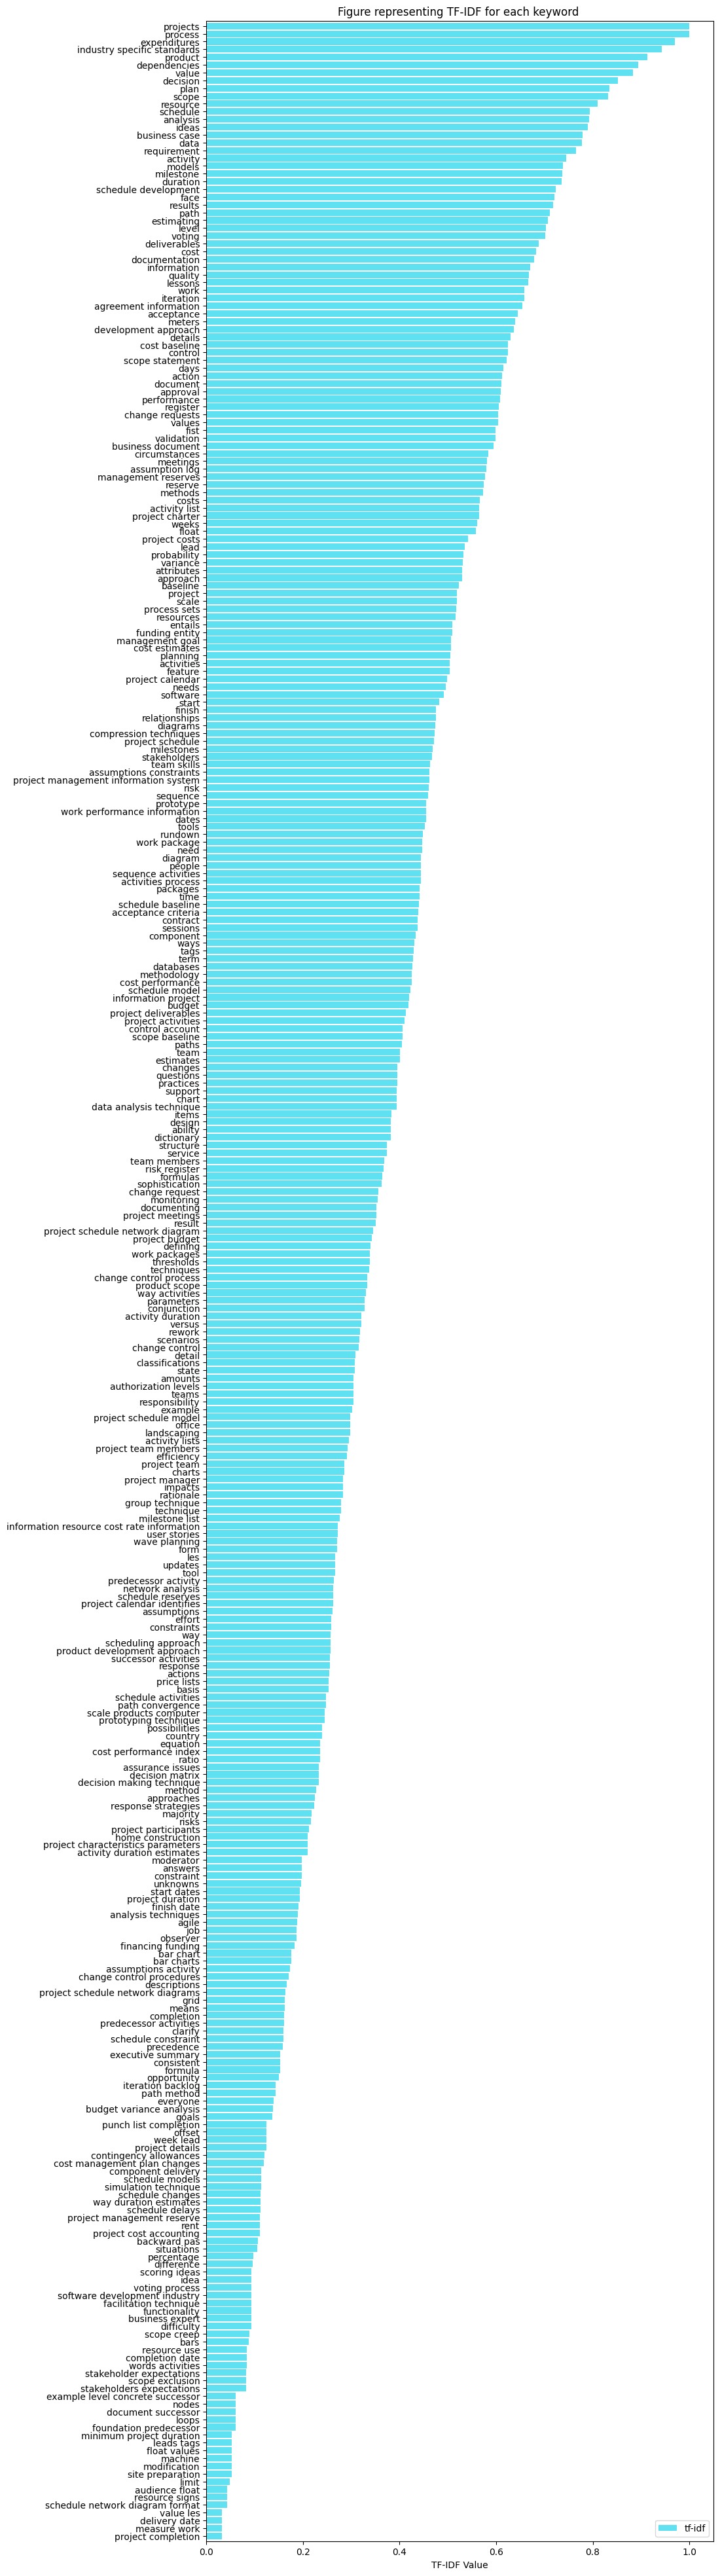

In [104]:
import matplotlib.pyplot as plt
plt.rcdefaults()
ax = df_concept_weight_filtred.plot(kind='barh', figsize=(10, 50), color='#60e1f2', zorder=2, width=0.85)

# Example data

y_pos = np.arange(df_concept_weight_filtred.shape[0])

ax.barh(y_pos, df_concept_weight_filtred['tf-idf'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_concept_weight_filtred['keyword'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('TF-IDF Value')
ax.set_title('Figure representing TF-IDF for each keyword ')

# LSA

In [105]:
from sklearn.decomposition import TruncatedSVD

In [106]:
svd = TruncatedSVD(n_components=48, n_iter=708, random_state=42)

sample_decomp = svd.fit_transform(df_weights.to_numpy())
Sigma = svd.singular_values_
U = sample_decomp/Sigma
V_T = svd.components_
V_T = svd.components_

In [107]:
print(U.shape)
print(Sigma.shape)
print(V_T.shape)

(216, 48)
(48,)
(48, 1300)


In [108]:
Sigma

array([5.29377691, 3.26740191, 3.07627696, 3.01024055, 2.64099777,
       2.54464552, 2.46529825, 2.34423549, 2.26789762, 2.12304173,
       2.00309371, 1.9934141 , 1.90108826, 1.87977614, 1.85237399,
       1.79693003, 1.76791936, 1.72459401, 1.65417885, 1.62136585,
       1.58616384, 1.55031984, 1.53066821, 1.52197136, 1.46257364,
       1.45325882, 1.42035629, 1.4077493 , 1.38527201, 1.36144511,
       1.33314696, 1.30929767, 1.29700115, 1.2828092 , 1.25691212,
       1.22515868, 1.2231788 , 1.20810346, 1.18736705, 1.17546717,
       1.16033269, 1.14940425, 1.12383637, 1.11006558, 1.10239686,
       1.08717425, 1.07492149, 1.0612613 ])

<AxesSubplot:>

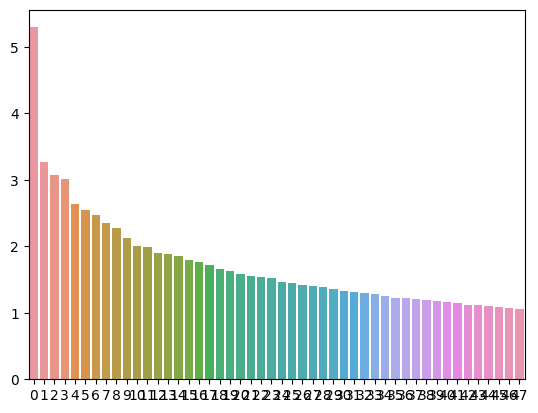

In [109]:
import seaborn as sns
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

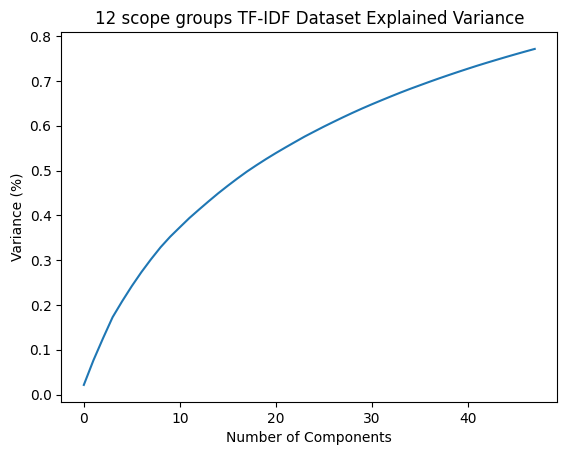

In [110]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('12 scope groups TF-IDF Dataset Explained Variance')
plt.show()

In [111]:
tsvd = TruncatedSVD(n_components=48, n_iter=708, random_state=42)
tsvd.fit(df_weights.to_numpy())
tsvd_mat = tsvd.transform(df_weights.to_numpy())
s_list = []

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [113]:
for clus in tqdm(range(2,80)):

    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering

    km.fit(tsvd_mat) # Run KMeans clustering

    s = silhouette_score(tsvd_mat, km.labels_)

    s_list.append(s)

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:37<00:00,  2.09it/s]


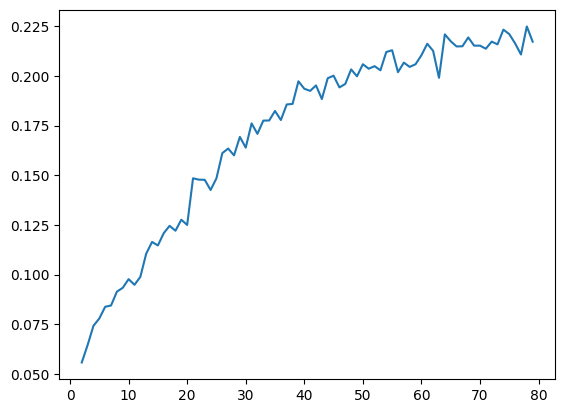

In [114]:
plt.plot(range(2,80), s_list)

plt.show()

In [115]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)

<AxesSubplot:>

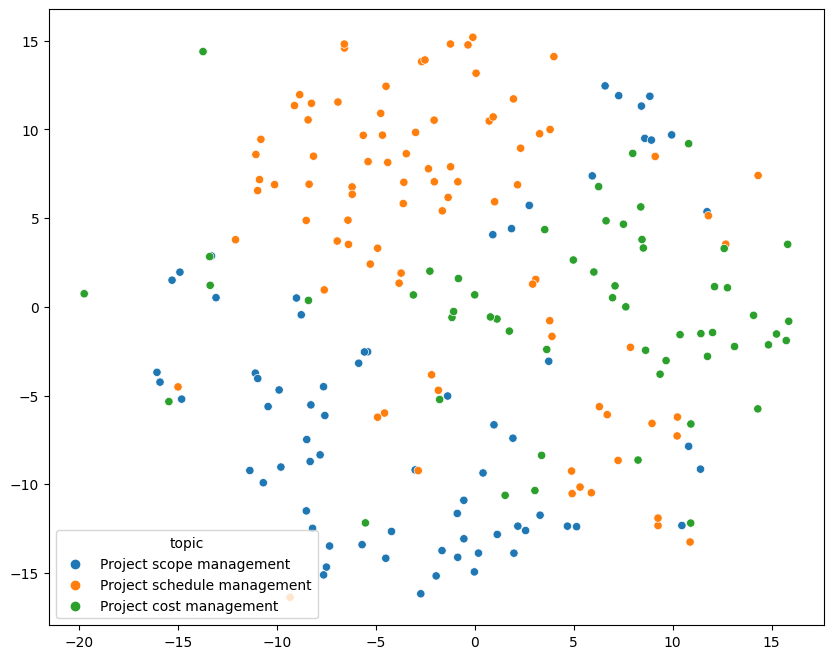

In [116]:
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=df['topic'])

In [117]:
from sklearn.metrics import pairwise_distances
import numpy as np
query = "examples of project scope management that explains more project concepts"
query_mat = tsvd.transform(tfidf_vect.transform([query]))
dist = pairwise_distances(X=tsvd_mat, Y=query_mat, metric='cosine')
print(df['topic'][np.argmin(dist.flatten())])
df['Definition'][np.argmin(dist.flatten())]

Project scope management


'The project scope statement is the description of the project scope major deliverables assumptions and constraints The project scope statement Document the entire scope including project and product scope It describes the project s deliverables in detail It also provides a common understanding of the project scope among project stakeholders It may contain explicit scope exclusion that can assist in managing stakeholder expectations It enables the project team to perform more detailed planning guides the project team s work during execution and provides the baseline for evaluating whether requests for changes or additional work are contained within or outside the project s boundaries The degree and level of detail to which the project scope statement defines the work that will be performed and the work that is excluded can help determine how well the project management team can control the overall project scope The detailed project scope statement either directly or by reference to oth

In [118]:
def concept_range_topic_detection(query):
    query_mat = tsvd.transform(tfidf_vect.transform([query]))
    dist = pairwise_distances(X=tsvd_mat, Y=query_mat, metric='cosine')
    return df['topic'][np.argmin(dist.flatten())]

In [119]:
concept_range_detected = []
for index,row in df_concept_weight_filtred.iterrows():
    concept_range_detected.append(concept_range_topic_detection(row['keyword']))

df_concept_weight_filtred['concept_range'] = concept_range_detected

In [120]:
df_concept_weight_filtred

,keyword,tf-idf,concept_range
859,projects,1.000000,Project scope management
1124,process,1.000000,Project scope management
933,expenditures,0.969523,Project cost management
255,industry specific standards,0.943037,Project scope management
195,product,0.913024,Project scope management
...,...,...,...
781,schedule network diagram format,0.043854,Project schedule management
833,value les,0.032016,Project cost management
1040,delivery date,0.032016,Project cost management
1098,measure work,0.032016,Project cost management


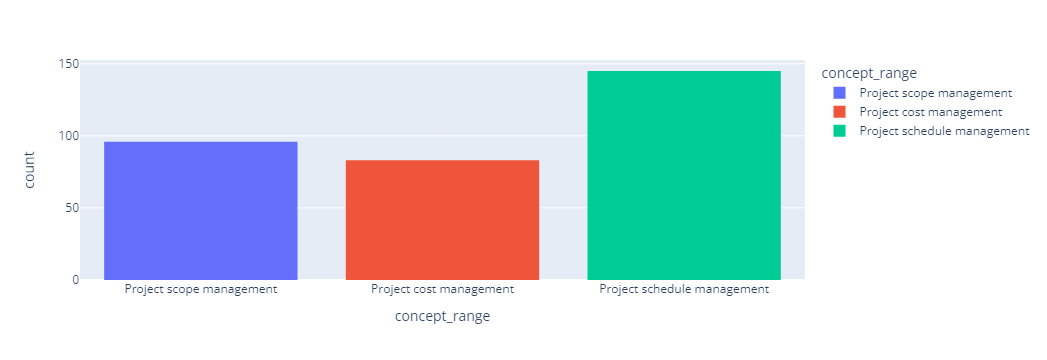

In [121]:
import plotly.express as px
# Here we use a column with categorical data
fig = px.histogram(df_concept_weight_filtred, x="concept_range", color="concept_range")
fig.show()

In [122]:
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer

import random



lemmatizer = WordNetLemmatizer()


In [123]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']

for index,row in df.iterrows():
    for definition in row['Definition']:

        # take each word and tokenize it
        w = nltk.word_tokenize(definition)
        words.extend(w)
        # adding documents
        documents.append((w, row['topic']))

        # adding classes to our class list
        if row['topic'] not in classes:
            classes.append(row['topic'])

In [ ]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

In [ ]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")

print (len(classes), "classes", classes)

print (len(words), "unique lemmatized words", words)


In [ ]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

In [ ]:
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [ ]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
hist = model.fit(np.array(train_x), np.array(train_y), epochs=20, batch_size=5, verbose=1)

In [ ]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

In [ ]:
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

In [ ]:
import json 
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import colorama 
colorama.init()
from colorama import Fore, Style, Back

import random
import pickle


def chat(): 

    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        p = bow(inp, words,show_details=False)
        res = model.predict(np.array([p]))[0]
        print(res)
        ERROR_THRESHOLD = 0.25
        results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
        # sort by strength of probability
        results.sort(key=lambda x: x[1], reverse=True)
        return_list = []
        for r in results:
            return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
        print(return_list)
        # result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
        #                                      truncating='post', maxlen=max_len))
        # print(result)
        # tag = lbl_encoder.inverse_transform([np.argmax(result)])

        # for i in data['intents']:
        #     if i['tag'] == tag:
        #         print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

        # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chat()